# Setting

In [1]:
import pymc3 as pm
import arviz
from matplotlib import gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy import stats

import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [3]:
def print_interval(low, high, text='confidence interval: '):
    #low, high = low*100, high*100
    p = (low+high)/2
    err = high - p
    #print(f'confidence interval: {p:.0f} ± {err:.2f} % [{low:.0f}, {high:.0f}]')
    print(f'{text}{p:.3f} ± {err:.4f}, [{low:.3f}, {high:.3f}]')
    
    
def test_hypothesis(pvalue, level=0.95):
    alpha = 1 - c_level
    if pvalue > alpha:
        s = 'Accept'
    else:
        s = 'Reject'
    print(f'{s} H0 (p-value = {pvalue:.4e})')

In [4]:
def survey(results, category_names, ax=None, figsize=(10, 5), fmt='%1.1f%%', cmap='Spectral', margin=0.25):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    cmap: 
        ex) 'bwr', 'coolwarm'
        see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    fmt: ex) '%g', '%1.1f%%'
    """
    height = figsize[1]/len(results)*.8
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps[cmap](
        np.linspace(margin, 1-margin, data.shape[1]))
        #np.linspace(0.25, 0.75, data.shape[1]))

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=height,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, fmt=fmt, label_type='center', color=text_color, fontweight='bold')
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.yaxis.set_tick_params(left=False)
    
    #return fig, ax
    return ax


# sample
category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],
    'Question 3': [35, 37, 7, 2, 19],
    'Question 4': [32, 11, 9, 15, 33],
    'Question 5': [21, 29, 5, 5, 40],
    'Question 6': [8, 19, 5, 30, 38]
}

#_ = survey(results, category_names)
#plt.show()

In [13]:
l_tab = 6

def print_head(x, x_all=None, l_tab=l_tab):
    n_tab = max([len(x) // l_tab + min(len(x) % l_tab, 1) for x in x_all])
    n = n_tab - len(x) // l_tab
    t = '\t' * n
    print(f'{x}{t}', end=' ')

In [5]:
c_level = .95 # 신뢰수준 95%
alpha = 1 - c_level # 유의수준 5%

# F01 신뢰수준과 표본오차
전국 성인 남녀 1000명이 조사에 응해주었다. 응답률은 5.4%, 표본오차는 95% 신뢰수준에서 ±3.1%포인트다

comments:
- 한 개의 긍정/부정 문항에 대하여 1000명 중 50%가 긍정한다면 100번중 95번의 경우 오차는 ±3.1% 이내. 
- 기사중 20대 여성은 160명이므로 20대 여성의 긍정/부정 문항의 최대 표본오차는 95% 신뢰수준에서 ±7.8% 

In [6]:
# 전체
n = 1000
k = round(n/2)

method = 'normal'
low, high = proportion_confint(k, n, alpha, method=method)
print_interval(low, high)

confidence interval: 0.500 ± 0.0310, [0.469, 0.531]


In [7]:
# 20대 여성
n = 160
k = round(n/2)

method = 'normal'
low, high = proportion_confint(k, n, alpha, method=method)
print_interval(low, high)

confidence interval: 0.500 ± 0.0775, [0.423, 0.577]


# F02 미혼의 결혼 의향
- 그림1. 
- 대상: 미혼 579명
- (그림에 없는 내용) 그런데 여기서 남녀 성별 격차가 나타난다. 미혼 남성은 65.7%가 결혼하고 싶다고 답한다. 그러나 여성은 54.5%가 결혼할 의향이 없다고 답한다. 

comments:
- 기사에서는 결혼 의향에 대해서 "남녀 간 ‘미스매치’가 일어난다. 이 성별 격차는 결혼 적령기인 30대에서 가장 크다"고 한다. 그러나 20대의 경우 결혼 의향에 남녀 차이가 있다고 할 수 없다. 또한 미혼 여성(전체, 20대, 30대 모두의 경우)의 결혼 의향이 50% 미만이라고 할 수 없다.

In [8]:
p1 = [.565, .435]
p2 = [.646, .354]
p3 = [.473, .527]
p4 = [.711, .289]
p5 = [.447, .553]
p6 = [.657, .343] # 미혼남
p7 = [.455, .545] # 미혼여

idx = ['전체', '20대남', '20대여', '30대남', '30대여', '미혼남', '미혼여']
cols = [['결혼']*2, ['의향 있음', '의향 없음']]
df = pd.DataFrame([p1,p2,p3,p4,p5,p6,p7], index=idx, columns=cols)

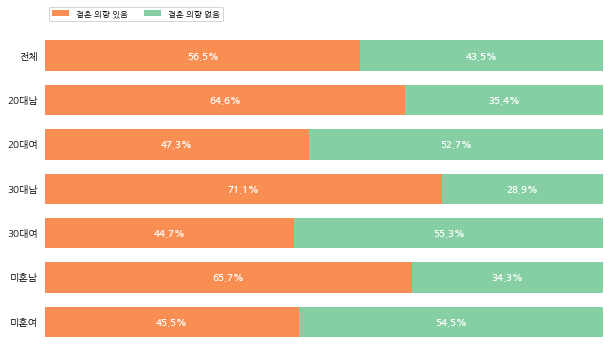

In [9]:
x = df.mul(100).to_dict(orient='split')
res = dict(zip(x['index'], x['data']))
cat = [' '.join(x) for x in x['columns']]
_ = survey(res, cat, figsize=(10,6))

In [10]:
# 나이별 인원수와 남녀 비율 동일 가정
n_single = 579
n_ages = round(n_single / (49-18+1) / 2) * 10 # 세대별 미혼남
n_ages

90

In [16]:
# '전체', '20대남', '20대여', '30대남', '30대여', '미혼남', '미혼여'
nums = [n_single, n_ages, n_ages, n_ages, n_ages, round(n_single/2), n_single-round(n_single/2)]
method = 'normal'

x = ' '.join(df.columns[0])
print(f'{x}:')
for i in range(len(nums)):
    print_head(df.index[i], df.index)
    n = nums[i]
    k = round(df.iloc[i,0] * n)
    low, high = proportion_confint(k, n, alpha, method=method)
    print_interval(low, high, '')

결혼 의향 있음:
전체	 0.565 ± 0.0404, [0.524, 0.605]
20대남	 0.644 ± 0.0989, [0.546, 0.743]
20대여	 0.478 ± 0.1032, [0.375, 0.581]
30대남	 0.711 ± 0.0936, [0.617, 0.805]
30대여	 0.444 ± 0.1027, [0.342, 0.547]
미혼남	 0.659 ± 0.0546, [0.604, 0.713]
미혼여	 0.453 ± 0.0574, [0.396, 0.511]


# F03 연애-결혼-출산 인식
- 그림2 
- 대상 응답자 전체 1000명
- 30대 남성(66.9%), 40대 남성(69.1%)에 비해 오히려 연애에 적극적일 것 같은 20대 남성이 연애에 더 시큰둥하다. 남성과 여성 모두 젊을수록 연애에 대한 집착이 약하다.
- 연애도, 결혼도 필수가 아닌데 출산이 필수일 리 없다

comments:
- (기사대로) ‘결혼은 반드시 해야 한다’는 인식에 대해서도 성별 격차가 있다.
- (기사대로) '연애는 반드시 해야 한다'는 문항에 ‘그렇지 않다’가 절반 이상을 차지하는 집단(연애 필수인 비율이 절반 미만)은 전체 성별·세대 가운데 20대 여성이 유일하다.
- 기사와 달리 30대 남성에 비해 20대 남성이 연애에 더 시큰둥하다고 할 수는 없다.
- 기사와 달리 여성만 젊을수록 연애에 대한 집착이 약하다
- (기사대로) ‘자녀는 반드시 낳아야 한다’는 문항에 대해서도 20대 여성은 강하게 반발한다. 결혼 의향 없는 미혼 집단을 제외하고 자녀가 필수라는 비율이 가장 낮다.
- 20데 여성 집단을 제외하고 결혼 의향 없는 미혼의 자녀 필수 비율이 가장 낮다. 비혼 출산의 가능성을 상상조차 하지 못하고 있는것은 아닐까? 
- 30대 여성은 (전체 집단 제외하고) 유일하게 결혼 필수보다 출산 필수 비율이 높다.

In [17]:
p1 = [.573, .224, .307] # 연애, 결혼, 출산의 필수 비율
p2 = [.560, .315, .355]
p3 = [.273, .083, .102]
p4 = [.669, .327, .377]
p5 = [.571, .096, .261]
p6 = [.240, .012, .071] 

idx = ['전체', '20대 남성', '20대 여성', '30대 남성', '30대 여성', '결혼 의향 없는 미혼']
cols = [['필수']*3, ['연애', '결혼', '출산']]
df = pd.DataFrame([p1,p2,p3,p4,p5,p6], index=idx, columns=cols)

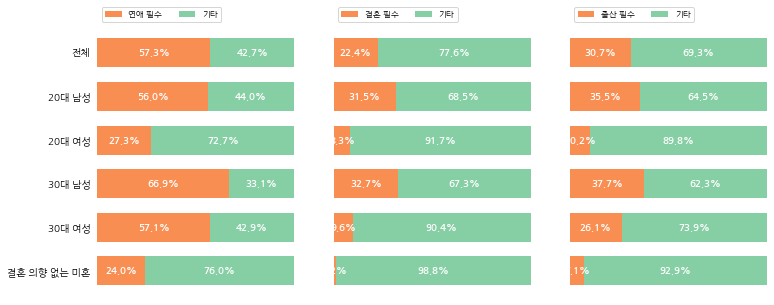

In [18]:
fig, axes = plt.subplots(1,3, figsize=(12,5), sharey=True)
for i in range(len(df.columns)):
    col = ' '.join(list(reversed(df.columns[i])))
    x = (df.iloc[:,i].to_frame(col)
           .assign(disagree=lambda x: 1-x[col])
           .rename(columns={col:col, 'disagree': '기타'})
           .mul(100).to_dict(orient='split'))
    res = dict(zip(x['index'], x['data']))
    cat = x['columns']
    _ = survey(res, cat, ax=axes[i])

In [19]:
# 나이별 남녀인원수 동일하다는 가정하에 계산한 세대별 남녀수(예 20대 여자)는 (우연히도) 실제 20대 여자수와 동일

# 나이별 인원수와 남녀 비율 동일 가정
n_all = 1000 # 전체 응답자
n_single2 = 252 # 결혼 의향 없는 미혼
n_ages = round(n_all / (49-18+1) / 2) * 10 # 세대별 남자
n_ages

160

In [21]:
nums = [n_all, n_ages, n_ages, n_ages, n_ages, n_single2]
method = 'normal'

for c in range(len(df.columns)):
    x = list(df.columns[c])
    x.reverse()
    x = ' '.join(x)
    print(f'{x}:')

    for i in range(len(nums)):
        x = df.index[i]
        print_head(x, df.index)
        n = nums[i]
        k = round(df.iloc[i,c] * n)
        low, high = proportion_confint(k, n, alpha, method=method)
        print_interval(low, high, '')
    print()

연애 필수:
전체		 0.573 ± 0.0307, [0.542, 0.604]
20대 남성	 0.562 ± 0.0769, [0.486, 0.639]
20대 여성	 0.275 ± 0.0692, [0.206, 0.344]
30대 남성	 0.669 ± 0.0729, [0.596, 0.742]
30대 여성	 0.569 ± 0.0767, [0.492, 0.645]
결혼 의향 없는 미혼	 0.238 ± 0.0526, [0.186, 0.291]

결혼 필수:
전체		 0.224 ± 0.0258, [0.198, 0.250]
20대 남성	 0.312 ± 0.0718, [0.241, 0.384]
20대 여성	 0.081 ± 0.0423, [0.039, 0.124]
30대 남성	 0.325 ± 0.0726, [0.252, 0.398]
30대 여성	 0.094 ± 0.0452, [0.049, 0.139]
결혼 의향 없는 미혼	 0.013 ± 0.0126, [0.000, 0.025]

출산 필수:
전체		 0.307 ± 0.0286, [0.278, 0.336]
20대 남성	 0.356 ± 0.0742, [0.282, 0.430]
20대 여성	 0.100 ± 0.0465, [0.054, 0.146]
30대 남성	 0.375 ± 0.0750, [0.300, 0.450]
30대 여성	 0.263 ± 0.0682, [0.194, 0.331]
결혼 의향 없는 미혼	 0.071 ± 0.0318, [0.040, 0.103]



# F04 결혼 관련 인식
- 그림3 
- 대상 응답자 전체 1000명
- 유독 20대 여성이 ‘희생’이라는 단어에 더 민감한 반응.
- 20대 여성 67.8%가 아무리 경제적으로 넉넉하더라도 일을 그만두어서는 안 된다고 답한다. 30대 여성의 응답(51%)보다도 높은 수치다.
- ‘자녀가 생기면 나의 사회적 성취를 이루기 어렵다’는 문항... 20대 여성은 전체 평균을 훌쩍 뛰어넘어 68.7%가 ‘그렇다’고 답했다. 30대 여성의 동일 응답(57.5%)보다 더 강한 반응이다.

comments:
- ‘결혼 관계를 위해 자신의 인생을 어느 정도 희생하는 것은 당연하다’는 문항에 대하여 '그렇다'고 대답한 비율은 20대 여성이 20대 남성이나 30대 여성과 다르다고 할 수 없다. 즉 20대 여성이 '희생'에 더 민감한 것은 아니다.
- (기사대로) 20대 여성은 30대 여성보다 높은 비율로 '아무리 경제적으로 넉넉하더라도 일을 그만두어서는 안 된다'고 답한다.
- ‘자녀가 생기면 나의 사회적 성취를 이루기 어렵다’는 문항에 대하여 '그렇다'고 대답한 비율은 20대 여성이 30대 여성과 다르다고 할 수 없다.
- 기사에서는 언급하지 않았지만 30대 남성이 눈에 띄는데 그들은 누구보다 더 결혼을 위해 희생할 준비가 되있고, (20대 남성과 함께) 결혼과 자녀가 사회적 성취에 방해된다고 생각하지 않는다.  
- 결혼을 위한 희생은 당연하다는 비율은 세대와 성별 차이가 없지만, 결혼/자녀가 사회적 성취에 방해된다는 비율은 성별 차이가 있다.

In [23]:
p1 = [.593, .362, .458] # 결혼을 위한 희생은 당연하다, 결혼은 사회적 성취에 방해된다, 자녀는 사회적 성취에 방해된다의 긍정 비율
p2 = [.538, .315, .373]
p3 = [.405, .475, .687]
p4 = [.724, .229, .351]
p5 = [.536, .504, .575]
p6 = [.387, .496, .627] 

idx = ['전체', '20대 남성', '20대 여성', '30대 남성', '30대 여성', '결혼 의향 없는 미혼']
cols = ['결혼을 위한 희생은 당연', '결혼은 사회적 성취에 방해', '자녀는 사회적 성취에 방해']
df = pd.DataFrame([p1,p2,p3,p4,p5,p6], index=idx, columns=cols)

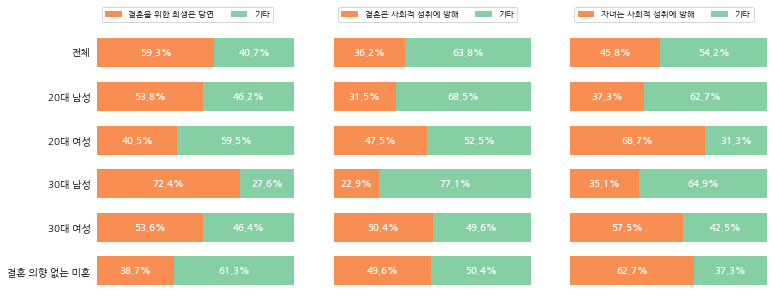

In [24]:
fig, axes = plt.subplots(1,3, figsize=(12,5), sharey=True)
for i in range(len(df.columns)):
    col = df.columns[i]
    x = (df.iloc[:,i].to_frame(col)
           .assign(disagree=lambda x: 1-x[col])
           .rename(columns={col:col, 'disagree': '기타'})
           .mul(100).to_dict(orient='split'))
    res = dict(zip(x['index'], x['data']))
    cat = x['columns']
    _ = survey(res, cat, ax=axes[i])

In [25]:
# 나이별 남녀인원수 동일하다는 가정하에 계산한 세대별 남녀수(예 20대 여자)는 (우연히도) 실제 20대 여자수와 동일

# 나이별 인원수와 남녀 비율 동일 가정
n_all = 1000 # 전체 응답자
n_single2 = 252 # 결혼 의향 없는 미혼
n_ages = round(n_all / (49-18+1) / 2) * 10 # 세대별 남자
n_ages

160

## CS1

In [26]:
nums = [n_all, n_ages, n_ages, n_ages, n_ages, n_single2]
method = 'normal'

for c in range(len(df.columns)):
    print(f'{df.columns[c]}:')
    for i in range(len(nums)):
        x = df.index[i]
        print_head(x, df.index)
        n = nums[i]
        k = round(df.iloc[i,c] * n)
        low, high = proportion_confint(k, n, alpha, method=method)
        print_interval(low, high, '')
    print()

결혼을 위한 희생은 당연:
전체		 0.593 ± 0.0304, [0.563, 0.623]
20대 남성	 0.537 ± 0.0773, [0.460, 0.615]
20대 여성	 0.406 ± 0.0761, [0.330, 0.482]
30대 남성	 0.725 ± 0.0692, [0.656, 0.794]
30대 여성	 0.537 ± 0.0773, [0.460, 0.615]
결혼 의향 없는 미혼	 0.389 ± 0.0602, [0.329, 0.449]

결혼은 사회적 성취에 방해:
전체		 0.362 ± 0.0298, [0.332, 0.392]
20대 남성	 0.312 ± 0.0718, [0.241, 0.384]
20대 여성	 0.475 ± 0.0774, [0.398, 0.552]
30대 남성	 0.231 ± 0.0653, [0.166, 0.297]
30대 여성	 0.506 ± 0.0775, [0.429, 0.584]
결혼 의향 없는 미혼	 0.496 ± 0.0617, [0.434, 0.558]

자녀는 사회적 성취에 방해:
전체		 0.458 ± 0.0309, [0.427, 0.489]
20대 남성	 0.375 ± 0.0750, [0.300, 0.450]
20대 여성	 0.688 ± 0.0718, [0.616, 0.759]
30대 남성	 0.350 ± 0.0739, [0.276, 0.424]
30대 여성	 0.575 ± 0.0766, [0.498, 0.652]
결혼 의향 없는 미혼	 0.627 ± 0.0597, [0.567, 0.687]



## CS2
20대 여성 67.8%가 아무리 경제적으로 넉넉하더라도 일을 그만두어서는 안 된다고 답한다. 30대 여성의 응답(51%)보다도 높은 수치다.

In [103]:
n = n_ages

# 20대 여성
k = round(.678 * n)
low, high = proportion_confint(k, n, alpha, method=method)
print('20대 여성: ', end='')
print_interval(low, high, '')

# 30대 여성
k = round(.51 * n)
print('30대 여성: ', end='')
low, high = proportion_confint(k, n, alpha, method=method)
print_interval(low, high, '')

20대 여성: 0.675 ± 0.0726, [0.602, 0.748]
30대 여성: 0.512 ± 0.0775, [0.435, 0.590]


## CS3
The chi-square test tests the null hypothesis that the categorical data has the same frequencies.

In [163]:
# 결혼을 위한 희생은 당연하다는 비율은 세대와 성별 차이가 있다고 할 수 없다.
# 결혼/자녀는 사회적 성취에 방해된다는 비율은 성별 차이가 있다.

df2 = df.iloc[1:-1].mul(n_ages).apply(lambda x: round(x)).astype(int)
idx = df2.iloc[:,0].index.str.split(' ', expand=True)


def chi2(df, axis=0):
    
    if axis == 0:
        var = df.index
        groups = df.columns
        run_test = lambda x, y: stats.chisquare(x.loc[:, y])
    else:
        var = df.columns
        groups = df.index
        run_test = lambda x, y: stats.chisquare(x.loc[y, :])
    
    for g in groups:
        t = ' & '.join(var)
        print(f'H0: ({g}) {t} 차이가 없다\t', end='')
        res = run_test(df, g)
        test_hypothesis(res[1])


for i in range(len(df2.columns)):
    t = df2.columns[i]
    print(f'{t}:')
        
    x = df2.iloc[:,i].to_frame().set_index(idx).iloc[:,0].unstack(level=-1)
    display(x)
    
    res = stats.chi2_contingency(x)
    print('H0: 세대 & 성별 독립\t\t', end='')
    test_hypothesis(res[1])
    
    _ = [chi2(x, a) for a in range(2)]
    
    print('\n'*1)

결혼을 위한 희생은 당연:


,남성,여성
20대,86,65
30대,116,86


H0: 세대 & 성별 독립		Accept H0 (p-value = 1.0000e+00)
H0: (남성) 20대 & 30대 차이가 없다	Reject H0 (p-value = 3.4790e-02)
H0: (여성) 20대 & 30대 차이가 없다	Accept H0 (p-value = 8.7459e-02)
H0: (20대) 남성 & 여성 차이가 없다	Accept H0 (p-value = 8.7459e-02)
H0: (30대) 남성 & 여성 차이가 없다	Reject H0 (p-value = 3.4790e-02)


결혼은 사회적 성취에 방해:


,남성,여성
20대,50,76
30대,37,81


H0: 세대 & 성별 독립		Accept H0 (p-value = 2.2123e-01)
H0: (남성) 20대 & 30대 차이가 없다	Accept H0 (p-value = 1.6339e-01)
H0: (여성) 20대 & 30대 차이가 없다	Accept H0 (p-value = 6.8986e-01)
H0: (20대) 남성 & 여성 차이가 없다	Reject H0 (p-value = 2.0544e-02)
H0: (30대) 남성 & 여성 차이가 없다	Reject H0 (p-value = 5.1102e-05)


자녀는 사회적 성취에 방해:


,남성,여성
20대,60,110
30대,56,92


H0: 세대 & 성별 독립		Accept H0 (p-value = 7.2389e-01)
H0: (남성) 20대 & 30대 차이가 없다	Accept H0 (p-value = 7.1035e-01)
H0: (여성) 20대 & 30대 차이가 없다	Accept H0 (p-value = 2.0534e-01)
H0: (20대) 남성 & 여성 차이가 없다	Reject H0 (p-value = 1.2565e-04)
H0: (30대) 남성 & 여성 차이가 없다	Reject H0 (p-value = 3.0846e-03)


